# Looking at GM coefficients in ACCESS-OM3

THis is a rough draft for now - don't read too much into it!! (AH - 15/12/25)

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
# esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
# esm_file='/g/data/ol01/outputs/access-om3-25km/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/x77/amh157/access-om3-paper-figs/


In [2]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [3]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


### Open the intake-esm datastore

In [5]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [6]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [7]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon", variable="KHTH_u")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
KHTH_u,Parameterized mesoscale eddy advection diffusi...,,zi:point yh:mean xq:point time: mean,m2 s-1
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
nv,vertex number,,,
time,time,,,days since 1900-01-01 00:00:00
time_bnds,time axis boundaries,,,days since 1900-01-01 00:00:00
xq,q point nominal longitude,,,degrees_east
yh,h point nominal latitude,,,degrees_north


In [8]:
KHTH = datastore.search(variable="KHTH_u", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


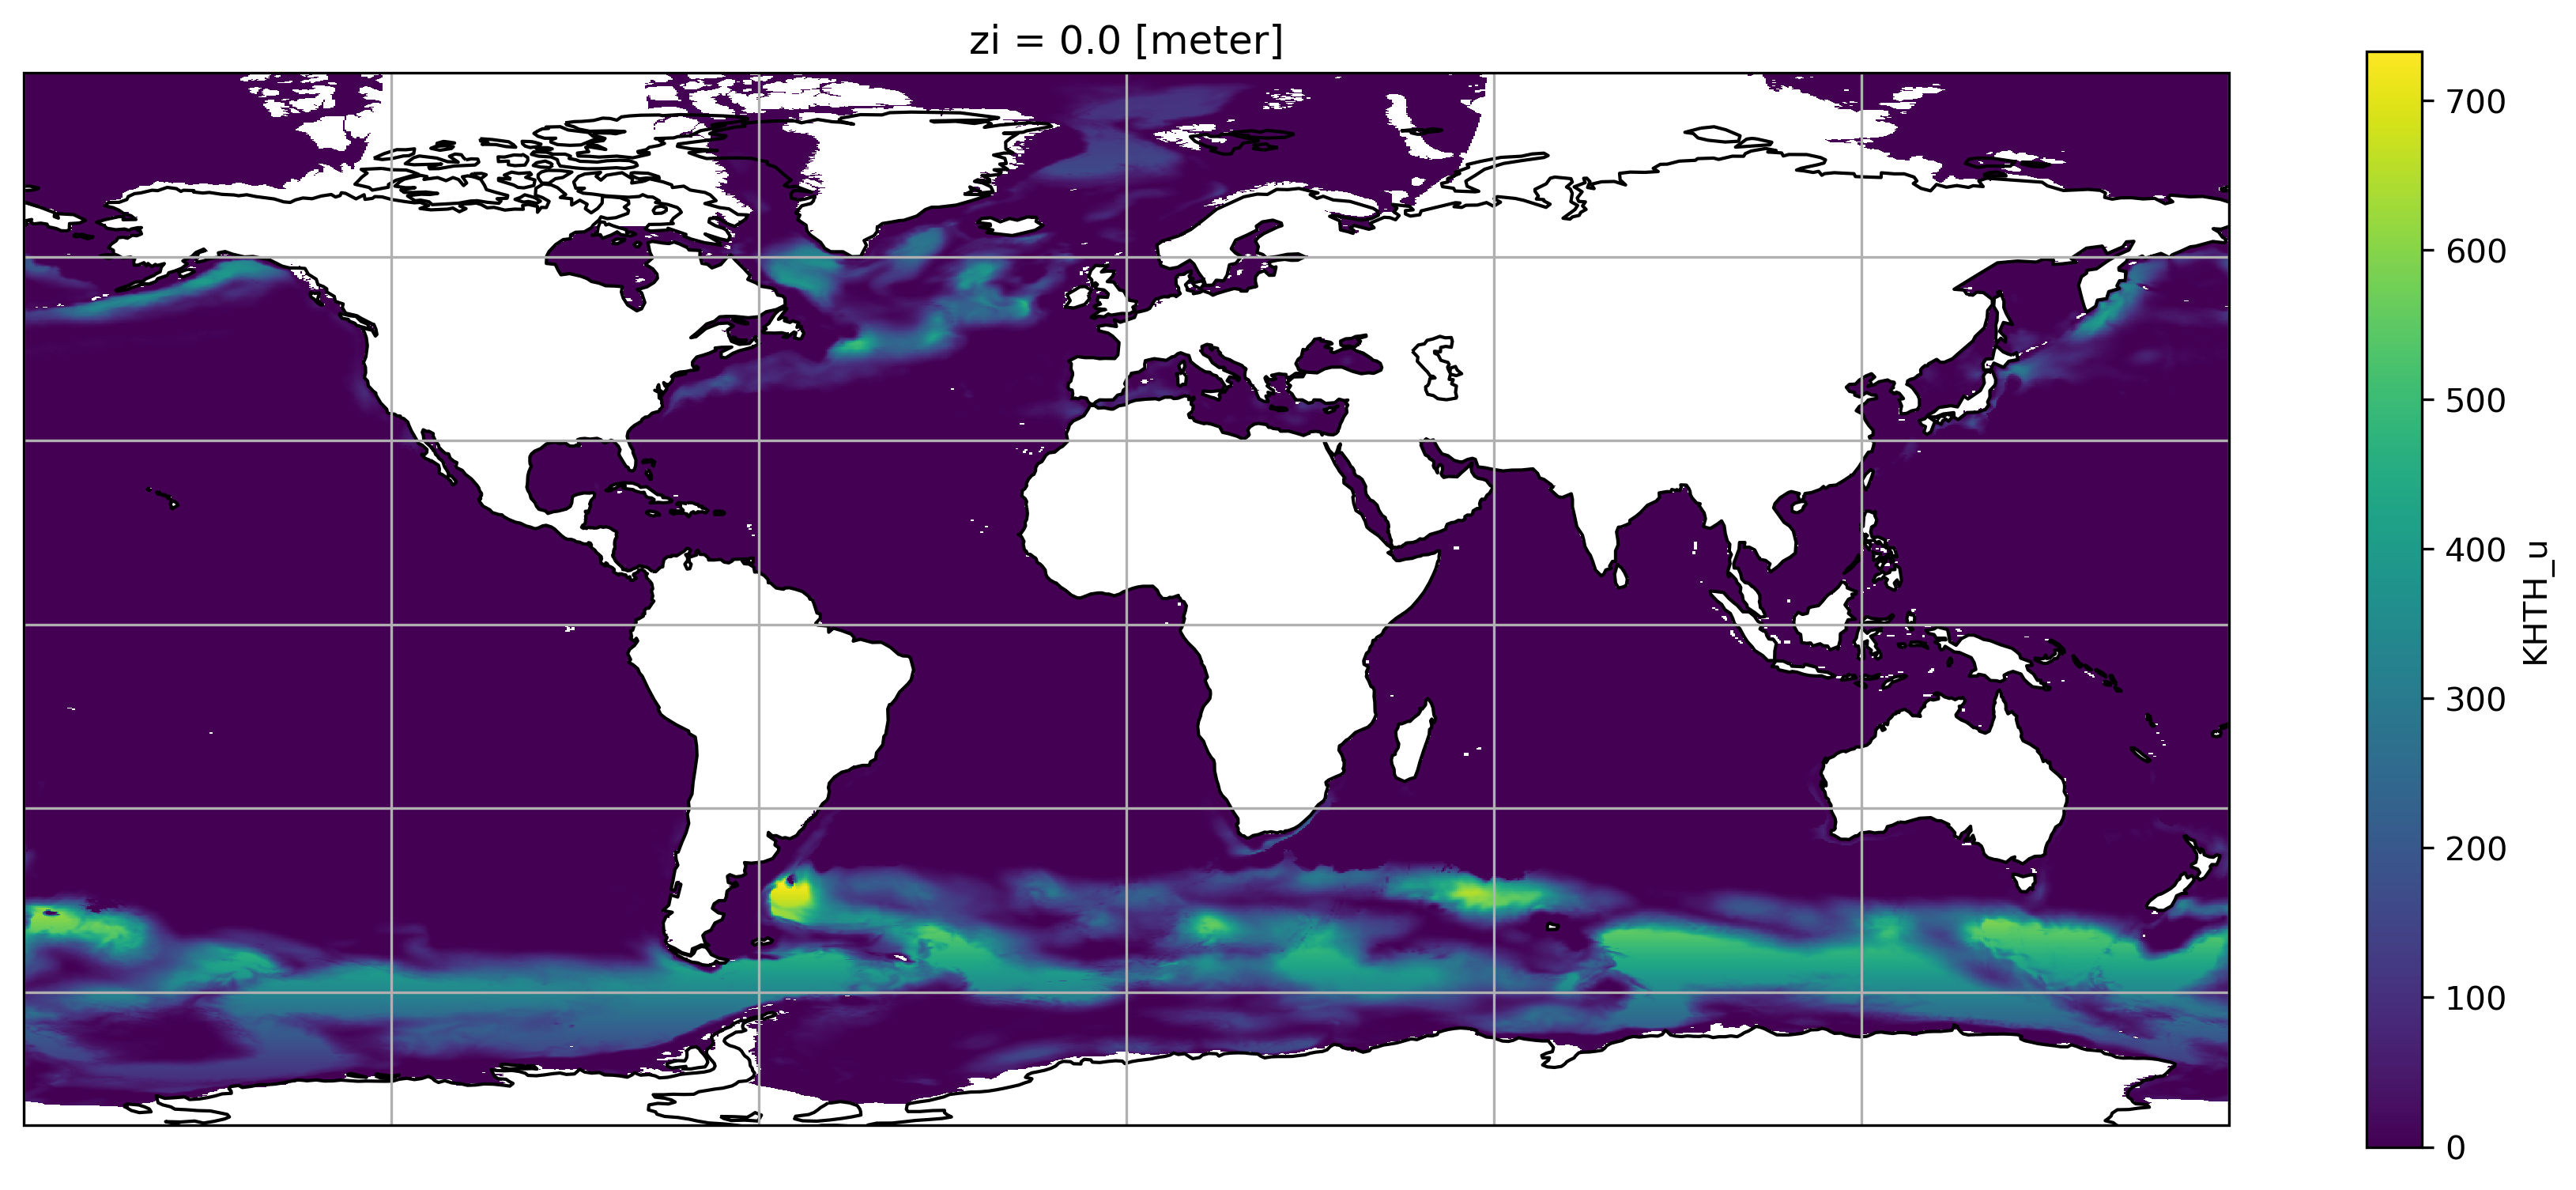

In [9]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

KHTH["KHTH_u"].isel(time=slice(-12,-1)).mean('time').isel(zi=0).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

In [10]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon", variable="diftrblo")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
diftrblo,Ocean Tracer Diffusivity due to Parameterized ...,ocean_tracer_diffusivity_due_to_parameterized_...,area:mean zl:mean yh:mean xh:mean time: mean,m2 s-1
nv,vertex number,,,
time,time,,,days since 1900-01-01 00:00:00
time_bnds,time axis boundaries,,,days since 1900-01-01 00:00:00
xh,h point nominal longitude,,,degrees_east
yh,h point nominal latitude,,,degrees_north


In [11]:
diftrblo = datastore.search(variable="diftrblo", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


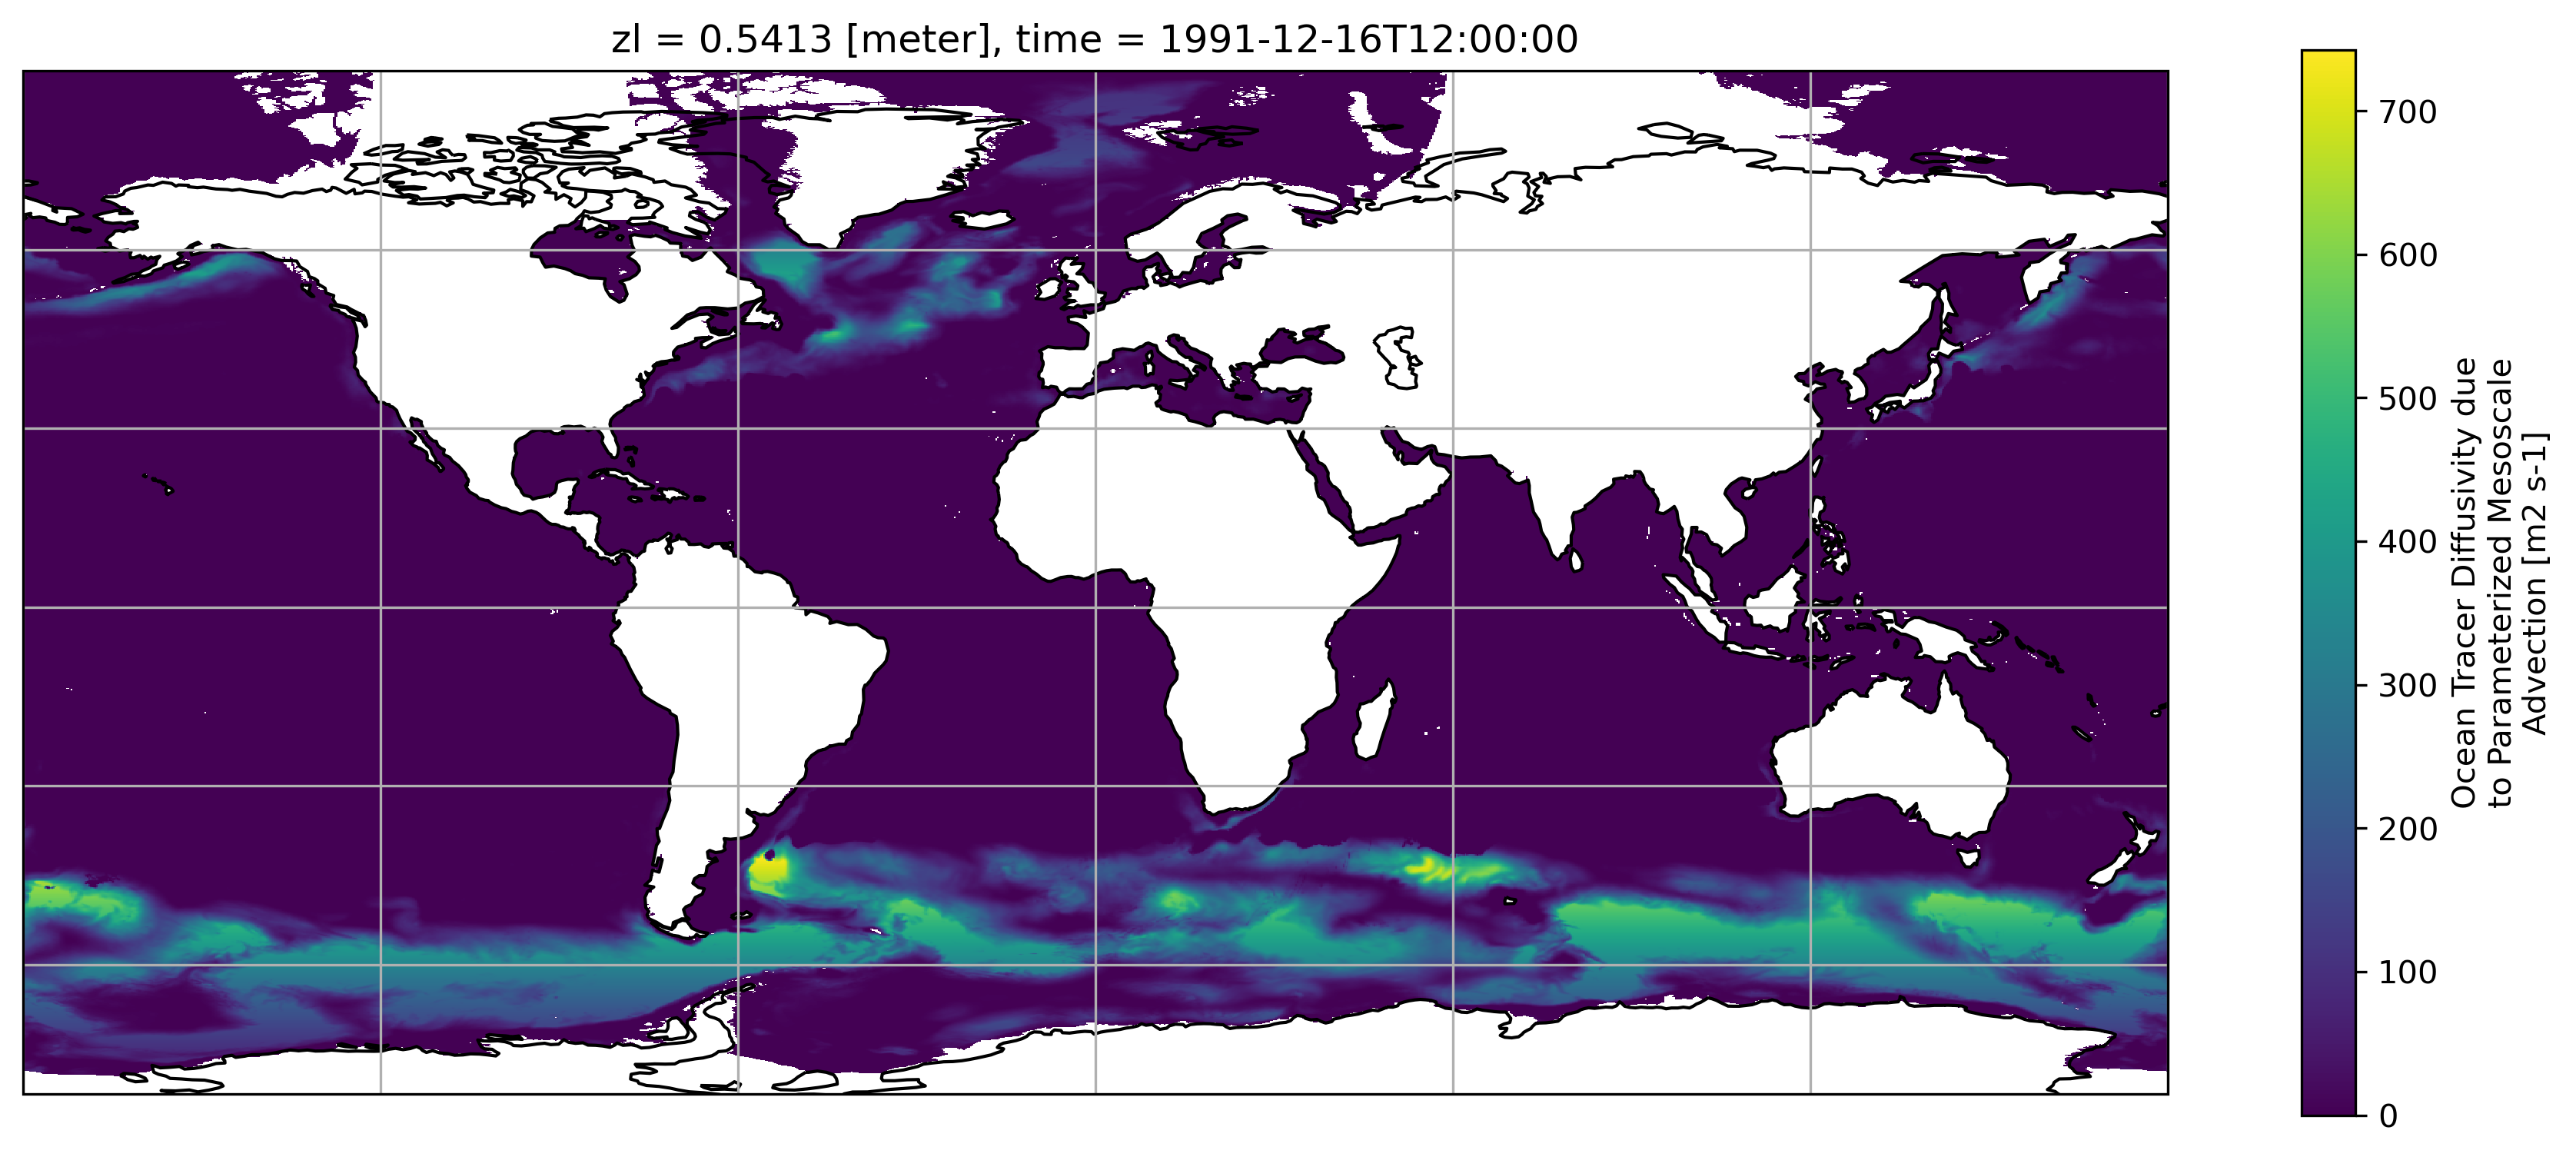

In [12]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

diftrblo["diftrblo"].isel(time=-1).isel(zl=0).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

In [13]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon", variable="diftrelo")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
diftrelo,Ocean Tracer Epineutral Laplacian Diffusivity,ocean_tracer_epineutral_laplacian_diffusivity,area:mean zi:point yh:mean xh:mean time: mean,m2 s-1
nv,vertex number,,,
time,time,,,days since 1900-01-01 00:00:00
time_bnds,time axis boundaries,,,days since 1900-01-01 00:00:00
xh,h point nominal longitude,,,degrees_east
yh,h point nominal latitude,,,degrees_north


In [14]:
diftrelo = datastore.search(variable="diftrelo", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


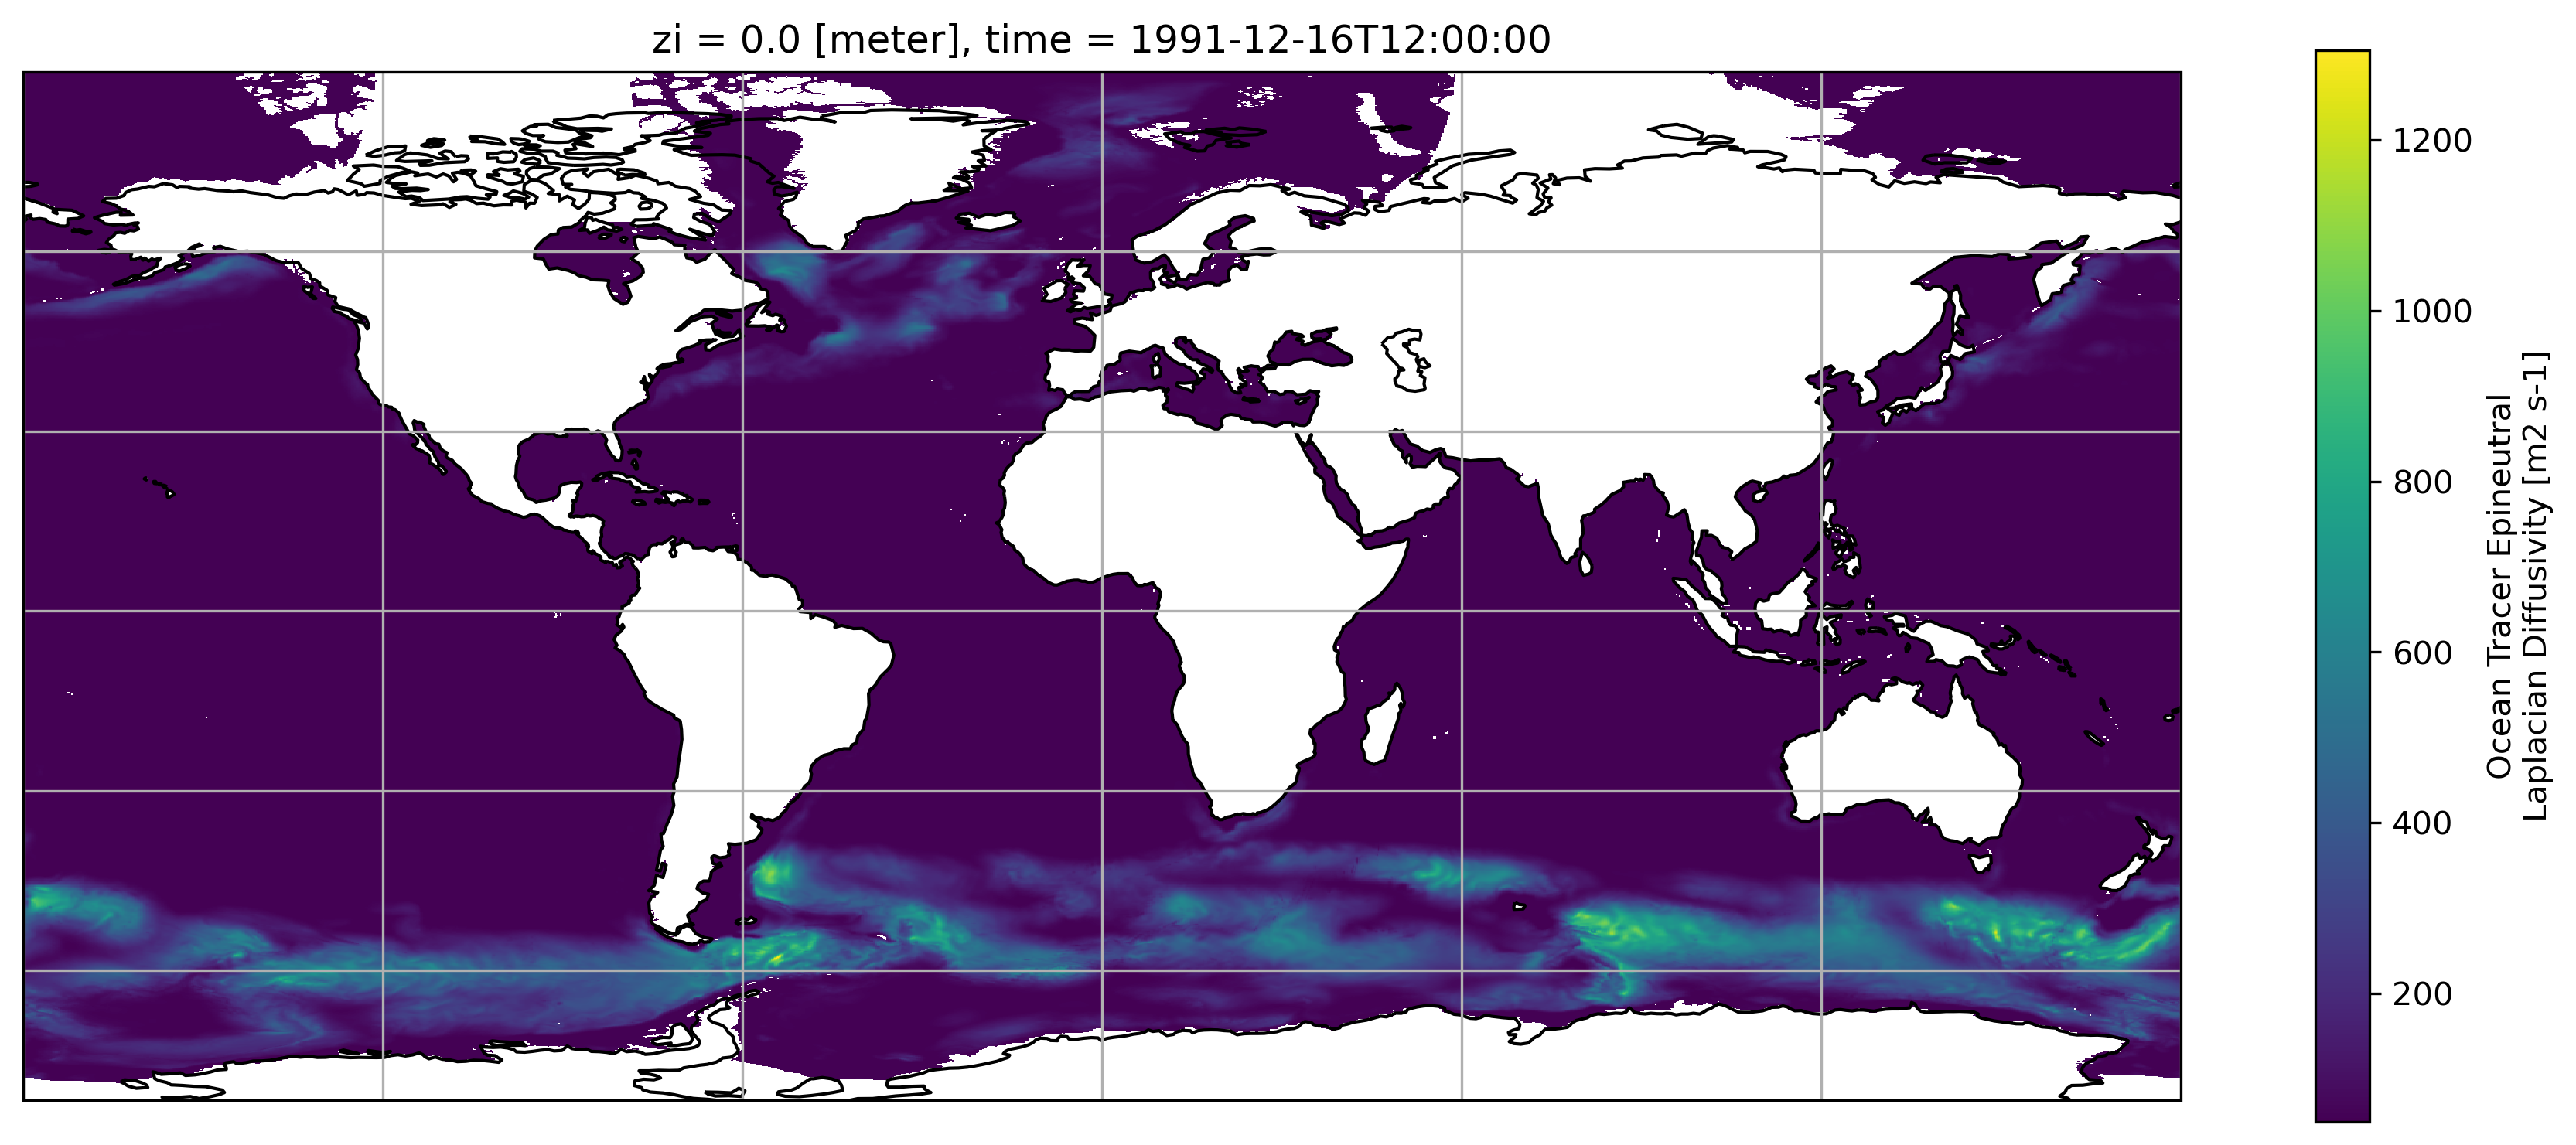

In [15]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

diftrelo["diftrelo"].isel(time=-1).isel(zi=0).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

# Comparison
The image below is from ACCESS-OM2. So, the GM & Redi correficients are much stronger in ACCESS-OM3 ...

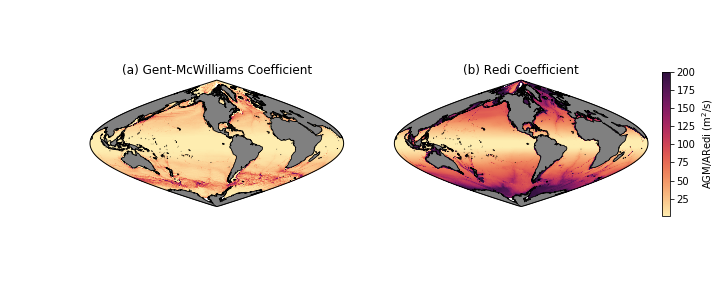

In [16]:
client.close()